# Abstracts LDA

* Load the abstracts from the research articles identified in 10_research_papers notebook.
* Create a corpus with the abstracts
* Tokenize
* Apply single LDA
* Apply ensemble LDA

In [20]:
import pandas as pd
import os
import PyPDF2
from collections import defaultdict
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import EnsembleLda
import numpy as np
from random import sample 

In [42]:
from matplotlib import pyplot as plt 

%matplotlib inline

## Load the abstracts 
* From the research articles on machine learning identified in 10_research_papers  notebook. Keep only the abstracts.
* Random sample 1000 papers

In [2]:
%%time

arxiv_ml_research = pd.read_csv('data/arxiv_ml_research.csv.zip')

CPU times: user 2 s, sys: 171 ms, total: 2.17 s
Wall time: 2.18 s


<timed exec>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
print(f"There are {arxiv_ml_research.shape[0]} research articles on machine learning in the dataset")

There are 207226 research articles on machine learning in the dataset


## Create a corpus with the abstracts

In [102]:
documents = arxiv_ml_research['abstract']

In [103]:
len(documents)

207226

### Random sample papers

In [104]:
sample_size = 10000
documents = sample(list(documents), sample_size)

### Tokenize

In [105]:
from gensim.parsing.preprocessing import preprocess_string

# remove common words and tokenize
texts = [
    preprocess_string(document)
    for document in documents
]

In [106]:
from collections import defaultdict

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

In [107]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

## Apply single LDA
Simple 1-topic LDA

In [108]:
lda_model = LdaModel(corpus, id2word=dictionary, num_topics=1)
corpus_lda = lda_model[corpus]

In [109]:
lda_model.print_topics()

[(0,
  '0.017*"model" + 0.014*"learn" + 0.010*"data" + 0.009*"method" + 0.008*"propos" + 0.008*"network" + 0.008*"train" + 0.007*"base" + 0.007*"gener" + 0.006*"perform"')]

## Apply ensemble LDA

In [110]:
topic_model_class = LdaModel
ensemble_workers = 12
num_models = ensemble_workers * 2
distance_workers = 12
num_topics = 100
passes = 2

In [111]:
ensemble = EnsembleLda(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=passes,
    num_models=num_models,
    topic_model_class=topic_model_class,
    ensemble_workers=ensemble_workers,
    distance_workers=distance_workers
)

* Compute all the topics. In this setup: num_topics * num_workers
* Compute the stable topics

In [112]:
print(len(ensemble.ttda))
print(len(ensemble.get_topics()))

2400
7


In [113]:
ensemble.print_topics()

[(0,
  '0.154*"graph" + 0.044*"node" + 0.024*"structur" + 0.022*"gnn" + 0.022*"network" + 0.017*"learn" + 0.015*"represent" + 0.015*"method" + 0.015*"propos" + 0.015*"inform"'),
 (1,
  '0.132*"network" + 0.074*"neural" + 0.036*"deep" + 0.025*"layer" + 0.023*"convolut" + 0.017*"architectur" + 0.015*"train" + 0.014*"learn" + 0.014*"model" + 0.011*"cnn"'),
 (2,
  '0.086*"attack" + 0.078*"adversari" + 0.039*"robust" + 0.038*"model" + 0.019*"perturb" + 0.017*"exampl" + 0.017*"train" + 0.015*"vulner" + 0.014*"defens" + 0.011*"input"'),
 (3,
  '0.164*"imag" + 0.017*"method" + 0.016*"model" + 0.014*"train" + 0.013*"propos" + 0.013*"deep" + 0.012*"reconstruct" + 0.010*"gener" + 0.010*"base" + 0.010*"segment"'),
 (4,
  '0.182*"cluster" + 0.019*"algorithm" + 0.016*"data" + 0.014*"method" + 0.013*"propos" + 0.011*"dataset" + 0.010*"mean" + 0.010*"spectral" + 0.009*"base" + 0.009*"result"'),
 (5,
  '0.111*"user" + 0.074*"recommend" + 0.040*"item" + 0.018*"base" + 0.017*"prefer" + 0.016*"model" + 0.

## Tuning

In [114]:
shape = ensemble.asymmetric_distance_matrix.shape
shape

(2400, 2400)

In [115]:
without_diagonal = ensemble.asymmetric_distance_matrix[~np.eye(shape[0], dtype=bool)].reshape(shape[0], -1)
print(without_diagonal.min(), without_diagonal.mean(), without_diagonal.max())

0.00707607284066436 0.7558168317569461 1.0


In [116]:
num_topics = []
eps = np.linspace(without_diagonal.min(), without_diagonal.max(), num=25)
for val in eps:
    ensemble.recluster(eps=val, min_samples=2, min_cores=2)
    topics = len(ensemble.get_topics())
    num_topics.append(topics)
    print(f"eps: {val} stable number of topics: {topics}")

eps: 0.00707607284066436 stable number of topics: 0
eps: 0.04844790313897001 stable number of topics: 10
eps: 0.08981973343727566 stable number of topics: 32
eps: 0.1311915637355813 stable number of topics: 34
eps: 0.17256339403388696 stable number of topics: 59
eps: 0.21393522433219261 stable number of topics: 73
eps: 0.25530705463049824 stable number of topics: 78
eps: 0.2966788849288039 stable number of topics: 79
eps: 0.33805071522710956 stable number of topics: 68
eps: 0.3794225455254152 stable number of topics: 49
eps: 0.42079437582372087 stable number of topics: 31
eps: 0.4621662061220265 stable number of topics: 15
eps: 0.5035380364203321 stable number of topics: 9
eps: 0.5449098667186378 stable number of topics: 8
eps: 0.5862816970169434 stable number of topics: 4
eps: 0.6276535273152491 stable number of topics: 2
eps: 0.6690253576135547 stable number of topics: 1
eps: 0.7103971879118604 stable number of topics: 1
eps: 0.7517690182101661 stable number of topics: 1
eps: 0.79314

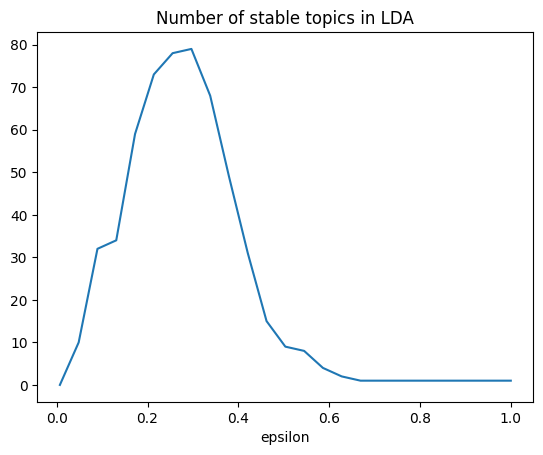

In [117]:
plt.plot(eps, num_topics)
plt.title("Number of stable topics in LDA")
plt.xlabel("epsilon")
plt.show()

In [118]:
eps = 0.5035380364203321
ensemble.recluster(eps=eps, min_samples=2, min_cores=2)
ensemble.print_topics()

[(0,
  '0.173*"cluster" + 0.041*"algorithm" + 0.011*"method" + 0.010*"depth" + 0.010*"propos" + 0.009*"result" + 0.008*"number" + 0.008*"data" + 0.008*"paper" + 0.007*"correl"'),
 (1,
  '0.104*"queri" + 0.018*"bia" + 0.018*"fair" + 0.015*"databas" + 0.013*"inform" + 0.012*"result" + 0.009*"retriev" + 0.008*"cell" + 0.007*"algorithm" + 0.006*"bias"'),
 (2,
  '0.098*"transform" + 0.053*"attent" + 0.027*"path" + 0.021*"relat" + 0.016*"plan" + 0.013*"base" + 0.012*"mechan" + 0.011*"token" + 0.011*"encod" + 0.010*"bert"'),
 (3,
  '0.075*"object" + 0.030*"social" + 0.012*"media" + 0.010*"video" + 0.008*"method" + 0.008*"point" + 0.008*"detect" + 0.008*"propos" + 0.008*"motion" + 0.008*"person"'),
 (4,
  '0.100*"network" + 0.056*"neural" + 0.025*"deep" + 0.024*"convolut" + 0.022*"layer" + 0.020*"cnn" + 0.016*"architectur" + 0.013*"train" + 0.012*"model" + 0.012*"learn"'),
 (5,
  '0.097*"agent" + 0.051*"human" + 0.014*"game" + 0.013*"interact" + 0.011*"environ" + 0.011*"behavior" + 0.011*"mult